# COMP5318 Week 12: Reinforcement Learning

Reinforcement learning (RL) has experienced a revolution in the past decade with the application of deep learning to the field. You may have heard of the achievements of the company DeepMind, which developed an RL system called AlphaGo. In 2016 and 2017, AlphaGo became the first computer to defeat top professional Go players. Although superhuman performance was reached in chess during the 1990s, AlphaZero (an extension of AlphaGo to other games) beats conventional chess programs with creative and risky strategies, and today's top grandmasters even study AlphaZero's games for inspiration.

It may seem that reinforcement learning focusses only on playing games. While games are a great sandbox to improve reinforcement learning techniques, there are also a number of practical applications where AI must interact with its environment, including autonomous driving and robotics.

In today's lab, we will strengthen your understanding of Q Learning and Deep Q Learning by training agents which use these strategies.

## 1. Setup

For the exercises in today's lab, we will need to install OpenAI Gym, a toolkit that provides a wide variety of simulated environments for RL.

In [2]:
import sys
!{sys.executable} -m pip install -U gym
!{sys.executable} -m pip install -U pyglet

Requirement already up-to-date: gym in /Users/kevin/.julia/conda/3/lib/python3.7/site-packages (0.23.1)
Requirement already up-to-date: pyglet in /Users/kevin/.julia/conda/3/lib/python3.7/site-packages (1.5.24)


In [3]:
import numpy as np
import os
import sklearn

import tensorflow as tf
from tensorflow import keras
import gym

# Make the notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 2. Q Learning

To demonstrate Q learning, we will implement an agent which can play a simple game by iteratively improving a table of Q values. The environment we will use is called ["Taxi-v3"](https://gym.openai.com/envs/Taxi-v3/), and it is ideal for this Q table approach since both the states and actions are discrete. The problem description is as follows:

> There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

This will become clearer after we take a look at a state. 

In [4]:
! pip install pygame
import pygame

# Create a Taxi-v3 environment
env = gym.make("Taxi-v3").env
env.reset()
# Render an image of the current state
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Our ASCII world is a 5x5 grid with walls and four locations. The colours have the following meaning:

- **Yellow brick** - Empty cab
- **Green brick** - Full cab (not shown in this state)
- **Blue letter** - Passenger position
- **Pink letter** - Destination 

Looking at the definitions in the [source code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py), we can deduce more information about how the states, actions and rewards are encoded.

- **Passenger locations**: 0 = R; 1 = G; 2 = Y; 3 = B; 4 = in taxi

- **Destinations**: 0 = R; 1 = G; 2 = Y; 3 = B

- **Actions**: 0 = move south; 1 = move north; 2 = move east; 3 = move west; 4 = pickup passenger; 5 = drop off passenger

- **Rewards**: 
    - -1 default reward per move, including hitting a wall (state won't change). 
    - -10 for erroneous pick up or drop off
    - +20 for successful pick up or drop off
    
Note how these rewards encourage taking the shortest path possible with no mistakes.

The state space is represented by: ```(taxi_row, taxi_col, passenger_location, destination)```.

***
**Question**: Can you describe the number of possible states by accounting for the different combinations of taxi positions, passenger positions, and destinations?

Using these definitions, let's encode an initial state.

In [5]:
# Encode start state
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)

# Get the state number
print("State number:", state)

# Render state
env.s = state
env.render()

State number: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Let's examine the result of taking the 6 possible actions. The first three elements of ```env.step```'s output are the new state, the reward, and a boolean to indicate if we have solved the task.

In [6]:
for action in range(6):
    print(env.step(action))

(142, -1, False, {'prob': 1.0})
(42, -1, False, {'prob': 1.0})
(62, -1, False, {'prob': 1.0})
(42, -1, False, {'prob': 1.0})
(42, -10, False, {'prob': 1.0})
(42, -10, False, {'prob': 1.0})


**Question**: Why doesn't the state change when we move west (action index 3)?

### A random action agent

As a baseline, let's create an agent whose strategy is to randomly choose fromt he six actions.

In [7]:
def random_agent_taxiv3(env):
    """Take in a Taxiv3 environment and perform random actions until solving the problem.
    
    Returns:
        A tuple of the environment, steps taken, reward, and penalities.
    """
    
    done = False
    steps = 0
    penalties = 0
    total_reward = 0
    
    while not done:
        
        # Randomly choose action and apply it
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        
        # Keep track of reward, penalities and number of steps
        total_reward += reward
        if reward == -10:
            penalties += 1
        steps += 1
    
    return env, steps, total_reward, penalties

The following cell puts our random agent into action from the start state 328. By rerunning it several times, you will see that the number of steps, reward, and penalties incurred can vary greatly.

In [8]:
# Set start state
env.s = 328

# Solve using random policy
env, steps, reward, penalties = random_agent_taxiv3(env)

print(f"Steps taken: {steps}")
print(f"Total reward: {reward}")
print(f"Penalties incurred: {penalties}")

Steps taken: 4470
Total reward: -17877
Penalties incurred: 1492


By inspection, state 328 should be solved in about 10 actions. Evidently a random policy is not a suitable approach!

### Learning with Q table

Let's instead build up a Q table, where each entry $Q(s, a)$ will approximate the expected cumulative reward from taking action a in state s.

In [9]:
# Initialise Q table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

The Q values are randomly initialised, so at the start our Q learning agent will perform no better than the random agent above. However, recall from the lecture that we can use the Bellman equation to improve our Q values by checking the actual rewards of immediate actions.

$$
\begin{array}{c}
\Delta Q(s, a)=R\left(s, a, s^{\prime}\right)+\max _{a^{\prime}} \gamma Q\left(s^{\prime}, a^{\prime}\right)-Q(s, a) \\
Q(s, a) \leftarrow Q(s, a)+\alpha \Delta Q(s, a)
\end{array}
$$

Equivalently:
$$
Q(s, a) \leftarrow (1-\alpha)Q(s, a) + \alpha\left(R\left(s, a, s^{\prime}\right) + \max _{a^{\prime}} \gamma Q\left(s^{\prime}, a^{\prime}\right)\right)
$$

$\alpha$ controls the speed of learning and $\gamma$ is the discount factor, controlling the value of future rewards relative to immediate ones.

We will also introduce an extra parameter $\epsilon$, which is a weighting between exploration (taking a random move) and exploitation (taking the current highest quality move). If the agent always checks the action with the highest quality at each state, we could fail to explore promising actions because of intially low Q values (a kind of local minima).

In [10]:
from IPython.display import clear_output

def q_table_learner(env, q_table, num_episodes=20000, alpha=0.1, gamma=0.6, epsilon=0.1):
    """Simple Q table learner function.
    
    Args:
        env: The gym environment to learn on
        q_table: Numpy array with shape (states, actions)
        num_episodes: How man episodes to use for training
        alpha: learning rate
        gamma: discount factor
        epsilon: proportion of exploration steps
        
    Returns:
        Trained q_table.
    """
    
    for episode in range (num_episodes):
        
        # Reset environment with a new start state
        state = env.reset()
        
        done = False

        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values
                
            # Take action and retrieve next state and reward
            next_state, reward, done, _ = env.step(action)
            next_max = np.max(q_table[next_state])
            
            # Update Q value
            q_table[state, action] = (1 - alpha) * q_table[state, action]\
                                     + alpha * (reward + gamma * next_max)
            
            state = next_state
        
        # Update progress display
        if episode % 100 == 0:
            clear_output(wait=True)
            print(f"Progress: {episode}/{num_episodes}")
    
    clear_output(wait=True)
    print(f"Progress: {episode+1}/{num_episodes}")
    print("Training complete")
    
    return q_table
        

In [11]:
env.seed(42)
q_table = q_table_learner(env, q_table)

Progress: 20000/20000
Training complete


For a sanity check on our Q table values, lets consider again consider state 328.

In [18]:
env.reset()
env.s = 328
env.render()

# Display Q table values for state 328
q_table[328]

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



array([-2.34859338, -2.27325184, -2.35201926, -2.34160407, -9.03830579,
       -8.92638849])

We can see that the best Q value is action 1 (go north), which by inspection is the quickest way to get to a solution. Both actions 0 and 2 (go south and go east) have lower Q values since they take a step in the wrong direction. Action 3 (go west) has a Q value somewhere in between: the taxi will hit the wall and stay at the same state, not advancing but also not moving away from the goal. Both pick up and drop off correctly have very negative rewards.

Let's look at another state where the taxi is at the correct location to pick up the passenger.

In [12]:
state = env.encode(0, 0, 0, 1) # (taxi row, taxi column, passenger index, destination index)
env.s = state
env.render()

# Display Q table values for state
q_table[state]

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



array([ -2.41289025,  -2.35910215,  -2.40925393,  -2.36271417,
        -2.27325184, -11.14965615])

Appropriately, the best action here is action 4 (pick up)!

Let's test out how our Q table agent performs after training by taking the actions with the highest Q value at each step. 

In [13]:
env.seed(42)
episodes = 100


total_steps = 0
total_penalties = 0
failures = 0

for episode in range(episodes):
    
    # Reset environment with a new start state
    state = env.reset()
    
    done = False
    steps = 0
    penalties = 0
    total_reward = 0
    

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _ = env.step(action)

        # Keep track of reward, penalities and number of steps
        total_reward += reward
        if reward == -10:
            penalties += 1
        steps += 1
        
        # If we have taken over 100 steps to solve the problem, record as a failure and move on
        # For example: we may be stuck running into a wall over and over based on a bad Q value
        if steps > 100:
            failures += 1
            break

    # Update progress display
    clear_output(wait=True)
    print(f"Progress: {episode+1}/{episodes}")
    
    total_penalties += penalties
    total_steps += steps

print(f"Results after evaluting on {episodes} episodes:")
print(f"Average timesteps per episode: {total_steps / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Total failed episodes: {failures}")

Progress: 100/100
Results after evaluting on 100 episodes:
Average timesteps per episode: 15.29
Average penalties per episode: 0.0
Total failed episodes: 3


After training our Q table using the Bellman equation, the number of timesteps per episode is very reasonable, and the model is very unlikely to make penalty actions due to the large negative reward. There are also very few failures, where we may be stuck running into a wall over and over based on a bad Q value.

## 3. Task

Write a function which takes a Taxi-v3 state number and a Q table, renders the state, and outputs a list of actions taken by the agent to sovle the problem. A skeleton is provided below.

In [19]:
def cab_solution(start_state, q_table):
    """Render a state and determine the steps taken by an agent using given Q table.
    
    Args:
        start_state: Start state number (int)
        q_table: Q table numpy array of shape (states, actions)
        
    Returns:
        List of actions (as strings) taken by the agent to solve the problem.
    """
    actions_taken = []
    action_names = ['south','north','east','west','pickup','dropoff']
    
    return actions_taken

In [20]:
cab_solution(232, q_table)

[]

## 4. Extension: Deep Q Learning

A Q table approach works well for simple games with a small number of discrete states and actions. For more complicated problems with many states/actions, or even continuous states/actions, a different approach is needed.

If you have time during the lab or after, please consider the following environment where the state space is continuous and we will use a neural network to approximate the Q values rather than a table.

CartPole is a classic reinforcement learning game created by eminent RL reserachers Sutton, Barto, and Anderson. The problem description from the OpenAI gym documentation is as follows:
> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 12 degrees from vertical, or the cart moves more than 2.4 units from the center.

If you've ever tried to balance a pole or broom on your hand, you'll know that this problem can be difficult!

The [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) contains more details about the problem encoding:

- Each state is represented by a tuple of 4 obersvations of the carts position, angle and their respective velocities:
```     
        Num     Observation               Min                     Max
        0       Cart Position             -2.4                    2.4
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.209 rad (-12 deg)    0.209 rad (12 deg)
        3       Pole Angular Velocity     -Inf                    Inf
```

- The two actions are encoded as
     - 0 = Push cart to the left
     - 1 = Push cart to the right

In [16]:
env = gym.make("CartPole-v1")
env.seed(42)

[42]

We can initialise the environment by calling ```reset()```, which returns a state:

In [17]:
state = env.reset()
state

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

Let's investigate how the state changes if we take add acceleration to the right.

In [18]:
action = 1  # accelerate right
state, reward, done, _ = env.step(action)
state

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Note the changes in the cart velocity and pole angular velocity (indices 2 and 4).

Rendering this environment (and most others in OpenAI Gym) is a little more complicated than for the taxi example, since the states are displayed as images. When we call ```env.render()```, a popup window (and possibly a warning in the jupyter notebook) may appear on your machine with the same image. While these may be a little annoying, they can usually be safely ignored and closed down at the end of the session by restarting the Python kernel. Those running on a server/cloud instance such as Colab may have more issues.

**If the popup windows cause issues on your machine, please see the Appendix for a workaround to run this part of the lab.**

In [19]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def plot_environment(env, figsize=(5,4)):
    """Renders state as an RGB image and plots it."""
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

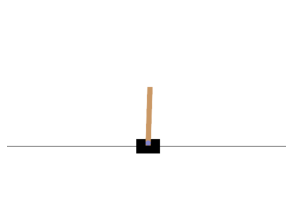

In [20]:
plot_environment(env)
plt.show()

***
**Question**: Can you match the state values printed above to the features of the rendered image?

**Solution**: All values are close to zero, but we can see the cart is slightly left of centre and the pole angle is positive, as expected from the state values. It is not possible to deduce the velocities from a still frame.
***

### Benchmark Policy
Before creating our Deep Q Learning approach, we can check how a benchmark policy performs. Suppose if the angle is positive, we accelerate the cart to the right, while if the angle is negative, we accelerate the cart to the left. 

In [21]:
def basic_policy(state):
    angle = state[2]
    return 0 if angle < 0 else 1

Let's measure how this performs on some episodes.

In [22]:
#env.seed(42)

# Run the basic policy on 500 episodes
#totals = []
#for episode in range(500):
#    episode_rewards = 0
 #   state = env.reset() # Reset the start state
  #  for step in range(200):
   #     action = basic_policy(state)
    #    state, reward, done, info = env.step(action)
     #   episode_rewards += reward
      #  if done:
       #     break
#    totals.append(episode_rewards)
    
#print(f"Mean reward: {np.mean(totals)}, Min reward: {np.min(totals)}, Max reward: {np.max(totals)}")

While the pole doesn't immediately fall over, we would hope to keep it upright for longer than this. We can animate how the policy progresses by saving frames at each step of an episode and using ```plot_animation``` which was defined above:

In [23]:
env.seed(42)
frames = []

state = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(state)

    state, reward, done, info = env.step(action)
    if done:
        print(f"Finished after {step} steps.")
        break
        
plot_animation(frames)

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


Finished after 54 steps.


### Defining and training a Deep Q Network
To approximate Q values for this problem, we will create a simple feedforward neural network. It will take in a state, and output Q values for each action. We will train the network using the Deep Q-Learning with Experience Replay algorithm from the lecture.

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

state_shape = env.observation_space.shape
n_outputs = env.action_space.n

# Define simple sequential model
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=state_shape), # Input shape determined by state shape
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(2) # Output shape determined by number of actions
])

As per the lecture, we will use an $\epsilon$-greedy policy during training to ensure the agent also explores the state space.

In [25]:
def epsilon_greedy_policy(state, epsilon=0):
    
    if np.random.rand() < epsilon:
        
        # Choose a random action
        return np.random.randint(n_outputs)
    else:
        
        # Choose best action as per model
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

To include the idea of experience replay that was covered in the lecture, we can store a deque of agent's experiences, encoded as tuples `(state, action, reward, next_state, done)`.

In [26]:
from collections import deque
replay_memory = deque(maxlen=2000)

Alongside model training, we need the model to generate experiences to learn from by playing a step using the epsilon greedy policy, and storing the experience in the replay memory.

In [27]:
def play_one_step(env, state, epsilon):
    """Find action using epsilon greedy policy and store the experience in replay memory.
    
    Args:
        env: The gym environment to take steps with
        state: Current state for the model to act on
        epsilon: Proportion of steps to explore rather than take best action
        
    Returns:
        Tuple of the next state, reward, done and info, as returned by env.step.
    """
    
    # Take action using epsilon greedy policy
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    
    # Store the experience in replay memory
    replay_memory.append((state, action, reward, next_state, done))
    
    return next_state, reward, done, info

We must also define a function to sample a random minibatch of transitions from the replay memory.

In [28]:
def sample_experiences(batch_size):
    """Sample experiences from replay memory.
    
    Args:
        batch_size: number of experiences to sample
    
    Returns:
        Five numpy arrays containing the states, actions, rewards, next_states, and dones
        for the minibatch.
    """
    
    # Randomly select experiences from the memory
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    
    # Create numpy arrays of each field from the sampled experiences
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    
    return states, actions, rewards, next_states, dones

Finally, we need to define a custom function which performs a training step for the model on a sample of experiences using the MSE loss between the outputted Q-values and the value after observing the actual reward of the immediate action $\left(R\left(s, a, s^{\prime}\right) + \max _{a^{\prime}} \gamma Q\left(s^{\prime}, a^{\prime}; \theta\right)\right)$. You may wish to align each part of this code with the pseudocode from the lecture.

In [29]:
# Some definitions to use during the training step
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    
    # Sample batch of experiences from replay memory
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Get model predictions of Q values
    next_Q_values = model.predict(next_states)
    
    # Use actual reward of next step to make targets
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    # Compute gradient updates for just these specific states and actions
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

We've now defined all the components of Deep Q-Learning with Experience Replay. Let's train the model.

Warning: The following cell may take a long time to train. At the expense of performance, you can reduce the number of episodes. It will output the traning progress, so you can keep track.

In [30]:
"""The following cell may have a long runtime."""
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

for episode in range(350):
    
    # Reset start state
    state = env.reset()
    
    # Generate experiences from this episode
    for step in range(200):
        
        # Initially, more likely to do random exploration
        # After enough episodes, more likely to use model outputs
        epsilon = max(1 - episode / 500, 0.01)
        
        state, reward, done, info = play_one_step(env, state, epsilon)
        if done:
            break
    
    # Reward for this example is the number of steps.
    rewards.append(step)
    
    # Save model weights when we achieve a best score
    if step >= best_score: 
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    
    # If we have enough experiences, perform a training step on the model
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

/Users/kevin/.julia/conda/3/lib/python3.7/site-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


Episode: 164, Steps: 21, eps: 0.672

: 

: 

We can visualise how the reward on each episode changed over time. Remember during training we still had some random actions according to the epsilon greedy policy, so we are just looking for a broad trend.

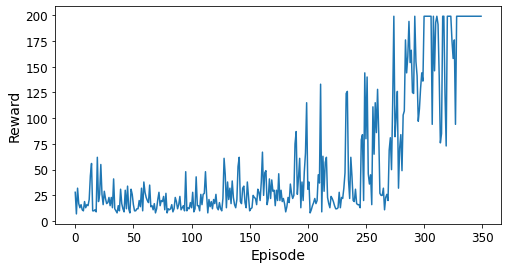

In [ ]:
# Plot how the reward from our model changed over time.
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.show()

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

## 5. Summary

In [21]:
# Create a Taxi-v3 environment
env = gym.make("Taxi-v3").env

# Initialise Q table
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Train Q table
env.seed(42)
q_table = q_table_learner(env, q_table)

Progress: 20000/20000
Training complete


## Acknowledgements

The Extension portion of this tutorial is based on:

Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly. and the associated code under Apache Licence 2.0.

## Appendix

If you are experiencing lots of trouble rendering the CartPole environment, you can try the following suggestion on your own machine or on a cloud environment such as Google Colaboratory.

In *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow* Geron provides a workaround for issues displaying the CartPole environment. 

He recommends installing [Xvfb](http://en.wikipedia.org/wiki/Xvfb) and then using the pyvirtualdisplay library which wraps Xvfb. 

On Debian or Ubuntu (such as Colab):
```bash
$ apt update
$ apt install -y xvfb
```

Then to install pyvirtualdisplay:

```bash
pip install -U pyvirtualdisplay
```
Following this, you can set up the display using the following cell:

In [25]:
!pip install pyvirtualdisplay
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb': 'Xvfb'

If you are still experiencing issues on your local machine, you may try these steps on Google Colab instead. 